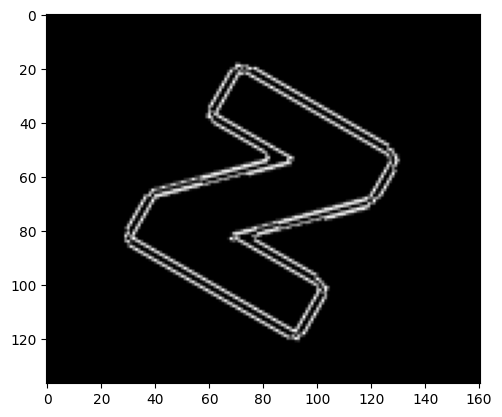

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os
import imutils

# removing obfuscating lines from the captcha
def remove_lines(img):
    kernel = np.ones((3,3),np.uint8)
    image = cv2.dilate(img, kernel, iterations = 1)
    edges = cv2.Canny(image, 100, 200)
    return edges

# detecting letter regions by dilating them and getting the contours
def get_contours(img):
    kernel = np.ones((3,3),np.uint8)
    img = cv2.dilate(img, kernel, iterations = 15)
    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)
    thresh = cv2.copyMakeBorder(thresh, 10, 10, 10, 10, cv2.BORDER_CONSTANT)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    return contours

# extracting the actual letter images by using the detected regions
def get_chars(contours):
    letter_image_regions = []

    for contour in contours:
            # Get the rectangle that contains the contour
            (x, y, w, h) = cv2.boundingRect(contour)

            # Check the dimensions of contours
            if w * h < 1500:
                # This contour is too small to be a letter!
                continue
            # Compare the width and height of the contour to detect letters that
            # are conjoined into one chunk
            elif w / h > 1.5:
                # This contour is too wide to be a single letter!
                # Split it in half into two letter regions!
                half_width = int(w / 2)
                letter_image_regions.append((x, y, half_width, h))
                letter_image_regions.append((x + half_width, y, half_width, h))
            else:
                # This is a normal letter by itself
                letter_image_regions.append((x, y, w, h))

            # If we found more or less than 4 letters in the captcha, our letter extraction
            # didn't work correcly. Skip the image instead of saving bad training data!
            # if len(letter_image_regions) != 3:
            #     continue
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    return letter_image_regions

# trimming blank space around the letter
def trim_letter(letter_image):
    gray = cv2.cvtColor(letter_image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = cv2.findNonZero(thresh) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    if x > 2 and y > 2:
        rect = gray[y-2:y+h+2, x-2:x+w+2]
    else:
	    rect = gray[y:y+h+2, x:x+w+2]
    return rect

max_h = 137
max_w = 161
for j in range(1, 25):
    img = cv2.imread(f'reference/{j}.png')
    edges = remove_lines(img)
    cv2.imwrite(f'temp.png', edges)
    pp_img = cv2.imread('temp.png')
    contours = get_contours(pp_img)
    captcha = get_chars(contours)
    x, y, w, h = captcha[0]
    letter_image = pp_img[y - 2:y + h + 2, x - 2:x + w + 2]
    letter = trim_letter(letter_image)
    top = int(0.5*(max_h - letter.shape[0]))
    bottom = max_h - letter.shape[0] - top
    left = int(0.5*(max_w - letter.shape[1]))
    right = max_w - letter.shape[1] - left
    letter = cv2.copyMakeBorder(letter, top, bottom, left, right, cv2.BORDER_CONSTANT, None, [0, 0, 0])
    for k in range(-3,4):
        rotated = imutils.rotate(letter, -10*k)
        cv2.imwrite(f'reference_save/{j}_{k+3}.png', rotated)